# Simulation
This jupyter notebook contains code for simulation runtimes for parameters: cube width and width multiple of sorting cube.

In [2]:
# Loading data
import numpy as np
import scipy
import time
import numba
from numba import njit
from numba.core import types
from numba.typed import Dict
import pandas as pd
import matplotlib.pyplot as plt
data_np = np.loadtxt('positions_large.xyz')
x_min, x_max = [np.min(data_np[:,0]), np.max(data_np[:,0])]
y_min, y_max = [np.min(data_np[:,1]), np.max(data_np[:,1])]
z_min, z_max = [np.min(data_np[:,2]), np.max(data_np[:,2])]
r = 0.05
range_cube_width = np.arange(start=0.15, stop=0.35, step=0.025)
range_sort_width_multiple = np.arange(start=2, stop=6, step=1)
N = 1
number_simulations = len(range_cube_width) * len(range_sort_width_multiple) * N
times_array_dict = np.zeros(shape=(len(range_cube_width), len(range_sort_width_multiple)))
times_array_count_1 = np.zeros(shape=(len(range_cube_width), len(range_sort_width_multiple)))
times_array_count_2 = np.zeros(shape=(len(range_cube_width), len(range_sort_width_multiple)))
simulations_count = 0
for n in range(N):
    for i_multiple, sort_width_multiple in enumerate(range_sort_width_multiple):
        for i_cube_width, cube_width in enumerate(range_cube_width):
            # Functions
            @njit(parallel=True)
            def count_dots_within_reach(dots: np.ndarray, r: float = r):
                '''
                Given "dots", it counts how many pairs are within distance r from each other.
                Method: Naive search
                '''
                dots_array_length = np.size(dots[:,0])
                count_array = np.zeros(dots_array_length) # We need to partition counts, in order to not create race condition
                for i in numba.prange(dots_array_length):
                    dot_a = dots[i]
                    for k in range(i+1, dots_array_length):
                            dot_b = dots[k]
                            distance = np.linalg.norm(dot_a - dot_b)
                            if distance<r:
                                count_array[i] += 1 # In order to not cause race condition, we need to add to its own element in an array
                count = np.sum(count_array) # and then sum the array
                return(count)

            @njit(parallel=True)
            def count_a_against_b(A: np.ndarray, B: np.ndarray, r: float = r):
                '''Given two matrixes A and B, for each dot in A, count how many of the dots in B it reaches.'''
                length_A = np.size(A[:,0]) # (Number of points in A)
                count_array = np.zeros(length_A) # In order not to create race condition, we have to partition our counts
                for i_a in numba.prange(length_A):
                    dot_a = A[i_a]
                    for dot_b in B:
                        distance = np.linalg.norm(dot_a - dot_b)
                        if distance<r:
                            count_array[i_a] += 1
                count = np.sum(count_array)
                return(count)

            @njit # There is probably not much to be gained from paralallisation here, but why not try!
            def get_infront_neighbours(cubes: Dict, key_A) -> np.ndarray:
                '''
                Gets relevant neighbours, see tuples in keys.
                For more in-depth explanation, see explanation of algorithm, why these exact neighbours are relevant.
                '''
                i, j, k = key_A
                B = np.array([0.0, 0.0, 0.0]) # Initialize numpy.array() of type floats and size 3
                keys = [(i, j+1, k), # The front up the cube
                        (i+1, j+1, k),
                        (i-1, j+1, k),
                        (i, j+1, k+1),
                        (i, j+1, k-1),
                        (i+1, j+1, k+1),
                        (i+1, j+1, k-1),
                        (i-1, j+1, k+1),
                        (i-1, j+1, k-1), ###
                        (i, j, k+1),
                        (i+1, j, k),
                        (i+1, j, k+1),
                        (i+1, j, k-1)]
                for key in keys: # For every key, append B with corresponding value
                    if key in cubes:
                        value = cubes[key]
                        B = np.append(B, value)
                B = np.reshape(B, (-1,3)) # Reshape so we get a matrix where each row corresponds to a dot of three float values
                B = B[1:] # Remove first initial row
                return(B)

            @njit(parallel=True)
            def creating_dict(empty_numba_dict: Dict, data_np: np.ndarray, x_min: float, x_max, y_min, y_max, z_min, z_max, cube_width: float=cube_width, sort_width_multiple: int=sort_width_multiple):
                '''
                This function takes data and creates a dictionary where the keys are indices of a given cube,
                and the value is points inside this cube.
                This function is actually not entirely complete, since some stuff can't be done inside the @njit wrapper,
                the rest of the function is completed outside the @njit wrapper.
                The function also returns an x, y and z grid.
                Inputs:
                empty_numba_dict: Empty dictionary to be copied
                data_np: Our data to put into the dictionary
                x_min: Minimum x-value of data_np
                cube_width: Width of each cube, ie. element in the future dictionary
                sort_width_multiple: Width of sorting cube will be, ie. sort_width_multiple*cube_width.
                '''
                sort_width = cube_width*sort_width_multiple
                number_of_partitions = 12 # Should be the same number of threads on the computer
                list_of_dicts = [empty_numba_dict.copy() for _ in range(number_of_partitions)] # Creates dictionaries for each partition
                x_sort_grid_to_be_partitioned = np.arange(x_min, x_max, step=sort_width) # This grid will be partitioned, the 3D space is partitioned into thinner slices of rectangular prisms
                y_sort_grid = np.arange(y_min, y_max, step=sort_width)
                z_sort_grid = np.arange(z_min, z_max, step=sort_width)

                x_sort_grid_partitions = np.array_split(x_sort_grid_to_be_partitioned, number_of_partitions)

                for idx_partition in numba.prange(number_of_partitions):
                    x_sort_grid = x_sort_grid_partitions[idx_partition]
                    for i_sort_idx_thilde, x_sort_coord in enumerate(x_sort_grid):
                        i_sort_idx = i_sort_idx_thilde + np.round((x_sort_grid[0]+x_min)/sort_width)
                        for j_sort_idx, y_sort_coord in enumerate(y_sort_grid):
                            for k_sort_idx, z_sort_coord in enumerate(z_sort_grid): # Look at one sorting box individually
                                sort_points = data_np[
                                    (data_np[:,0] >= x_sort_coord) & (data_np[:,0] < x_sort_coord+sort_width) &
                                    (data_np[:,1] >= y_sort_coord) & (data_np[:,1] < y_sort_coord+sort_width) &
                                    (data_np[:,2] >= z_sort_coord) & (data_np[:,2] < z_sort_coord+sort_width)
                                ]
                                if sort_points.size==0: # If empty, go to next box
                                    continue
                                x_start_idx = i_sort_idx*sort_width_multiple
                                y_start_idx = j_sort_idx*sort_width_multiple
                                z_start_idx = k_sort_idx*sort_width_multiple

                                x_end_coord = x_sort_coord + cube_width*sort_width_multiple
                                y_end_coord = y_sort_coord + cube_width*sort_width_multiple
                                z_end_coord = z_sort_coord + cube_width*sort_width_multiple

                                x_sub_grid = np.arange(x_sort_coord, x_end_coord, step=cube_width) # Not +cube_width in to=
                                y_sub_grid = np.arange(y_sort_coord, y_end_coord, step=cube_width)
                                z_sub_grid = np.arange(z_sort_coord, z_end_coord, step=cube_width)
                                for i, x_coord in enumerate(x_sub_grid):
                                    i_global = i + x_start_idx
                                    for j, y_coord in enumerate(y_sub_grid):
                                        j_global = j + y_start_idx
                                        for k, z_coord in enumerate(z_sub_grid):
                                            # As soon as we get here, we need to alter i inorder to account for the fact that we are looking at another cube
                                            k_global = k + z_start_idx
                                            cube_points = data_np[
                                                (data_np[:,0] >= x_coord) & (data_np[:,0] < x_coord+cube_width) &
                                                (data_np[:,1] >= y_coord) & (data_np[:,1] < y_coord+cube_width) &
                                                (data_np[:,2] >= z_coord) & (data_np[:,2] < z_coord+cube_width)
                                            ]
                                            if cube_points.size!=0: # If it is NOT empty, create a element in dictionary
                                                # Here ChatGpt, this if statement should never be True!!!
                                                list_of_dicts[idx_partition][(i_global, j_global, k_global)] = cube_points

                x_grid = np.arange(x_min, x_max+cube_width, step=cube_width)
                y_grid = np.arange(y_min, y_max+cube_width, step=cube_width)
                z_grid = np.arange(z_min, z_max+cube_width, step=cube_width)
                return(list_of_dicts, x_grid, y_grid, z_grid)

            @njit(parallel=True)
            def counting_part_1(cubes_numba_dict, r: float=r):
                '''
                Iterating through every cube, getting the "relevant neighbours", and counting how many of the dots inside the current cube
                "reaches" the dots inside any of the neighbours.
                '''
                count = 0
                keys_array = list(cubes_numba_dict.keys())
                number_of_keys = len(keys_array)
                count_array = np.zeros(number_of_keys) # Create array in order not to create race condition
                for i in numba.prange(number_of_keys):
                    A_key = keys_array[i]
                    A = cubes_numba_dict[A_key]
                    B = get_infront_neighbours(cubes_numba_dict, A_key)
                    count_array[i] += count_a_against_b(A, B, r=r)
                count = np.sum(count_array)
                return(count)

            @njit # TODO: Try to paralellise here, fix count_part_2
            def counting_part_2(cubes_numba_dict, r: float=r):
                '''
                Iterate through every cube in the dictionary, and perform counts_dots_within_reach on the cube.
                Ie. calculate how many points within the cube that are within "reach" to each other.
                '''
                count = 0
                cube_values = cubes_numba_dict.values()
                #number_of_cubes = np.size(cube_values[:,0])
                for points in cube_values:
                    if np.size(points)>1: # If cube empty or only have one dot, don't bother calculating.
                        count += count_dots_within_reach(points, r=r)
                return(count)

            # Start timer
            print("\n")
            print("########### SMART METHOD START ###########")

            # Creating dictionary
            start_time = time.perf_counter()
            cubes_numba_dict = Dict.empty( # Creating empty numba dictionary
                key_type=types.UniTuple(types.int32, 3), # Keys are tuples
                value_type=types.float64[:,:] # (Matrix of float values)
            )
            list_of_dicts, x_grid, y_grid, z_grid = creating_dict(cubes_numba_dict, data_np, x_min, x_max, y_min, y_max, z_min, z_max, cube_width, sort_width_multiple)
            for d in list_of_dicts: # Iterating through every dict in list_of_dicts and putting every filling up the cubes_numba_dict
                for key, value in d.items():
                    cubes_numba_dict[key] = value
            create_dict_time = time.perf_counter()
            print(f"It took: {create_dict_time-start_time} to create dictionary.")

            times_array_dict[i_cube_width, i_multiple] = times_array_dict[i_cube_width, i_multiple] + create_dict_time-start_time

            # Counting part 1
            count_part_1 = counting_part_1(cubes_numba_dict)
            print(f"Count part 1: {count_part_1}")
            count_part_1_time = time.perf_counter()
            print(f"It took: {count_part_1_time-create_dict_time} to count part 1.")

            times_array_count_1[i_cube_width, i_multiple] = times_array_count_1[i_cube_width, i_multiple] + count_part_1_time-create_dict_time
            
            # Counting part 2
            count_part_2 = counting_part_2(cubes_numba_dict)
            print(f"Count part 2: {count_part_2}")
            count_part_2_time = time.perf_counter()
            print(f"It took: {count_part_2_time-count_part_1_time} to count part 2.")

            times_array_count_2[i_cube_width, i_multiple] = times_array_count_2[i_cube_width, i_multiple] + count_part_2_time-count_part_1_time

            count_total = count_part_1 + count_part_2

            simulations_count += 1
            print(f"Total count: {count_total}")
            print(f"Computed: cube width = {cube_width}")
            print(f"n = {n}")
            print(f"Simulations: {simulations_count} / {number_simulations}")
total_times = (times_array_dict + times_array_count_1 + times_array_count_2)/N



########### SMART METHOD START ###########
Count part 1: 429309.0
It took: 6.812696400098503 to count part 1.
Count part 2: 1007656.0
It took: 1.8679476999677718 to count part 2.
Total count: 1436965.0
Computed: cube width = 0.15
n = 0
Simulations: 1 / 32


########### SMART METHOD START ###########
Count part 1: 464133.0
It took: 7.283493000082672 to count part 1.
Count part 2: 972832.0
It took: 2.084752199938521 to count part 2.
Total count: 1436965.0
Computed: cube width = 0.175
n = 0
Simulations: 2 / 32


########### SMART METHOD START ###########
Count part 1: 325566.0
It took: 9.430005500093102 to count part 1.
Count part 2: 1111399.0
It took: 1.9747919999063015 to count part 2.
Total count: 1436965.0
Computed: cube width = 0.19999999999999998
n = 0
Simulations: 3 / 32


########### SMART METHOD START ###########
Count part 1: 295655.0
It took: 9.377579899970442 to count part 1.
Count part 2: 1141310.0
It took: 2.1503618999850005 to count part 2.
Total count: 1436965.0
Computed

In [3]:
import pandas as pd
import openpyxl

# Exports data to excel
def data_to_excel(data: np.ndarray, filename: str, range_x: np.ndarray=range_sort_width_multiple, range_y: np.ndarray=range_cube_width):
    df = pd.DataFrame(data, columns=range_x, index=range_y)
    df.to_excel(filename, index=True)
    return(None)

#data_to_excel(times_array_count_1, filename="count_1_times_sim_2.xlsx")
#data_to_excel(times_array_count_2, filename="count_2_times_sim_2.xlsx")
#data_to_excel(times_array_dict, filename="creating_dict_times_sim_2.xlsx")

Text(117.24999999999997, 0.5, 'Width of cubes')

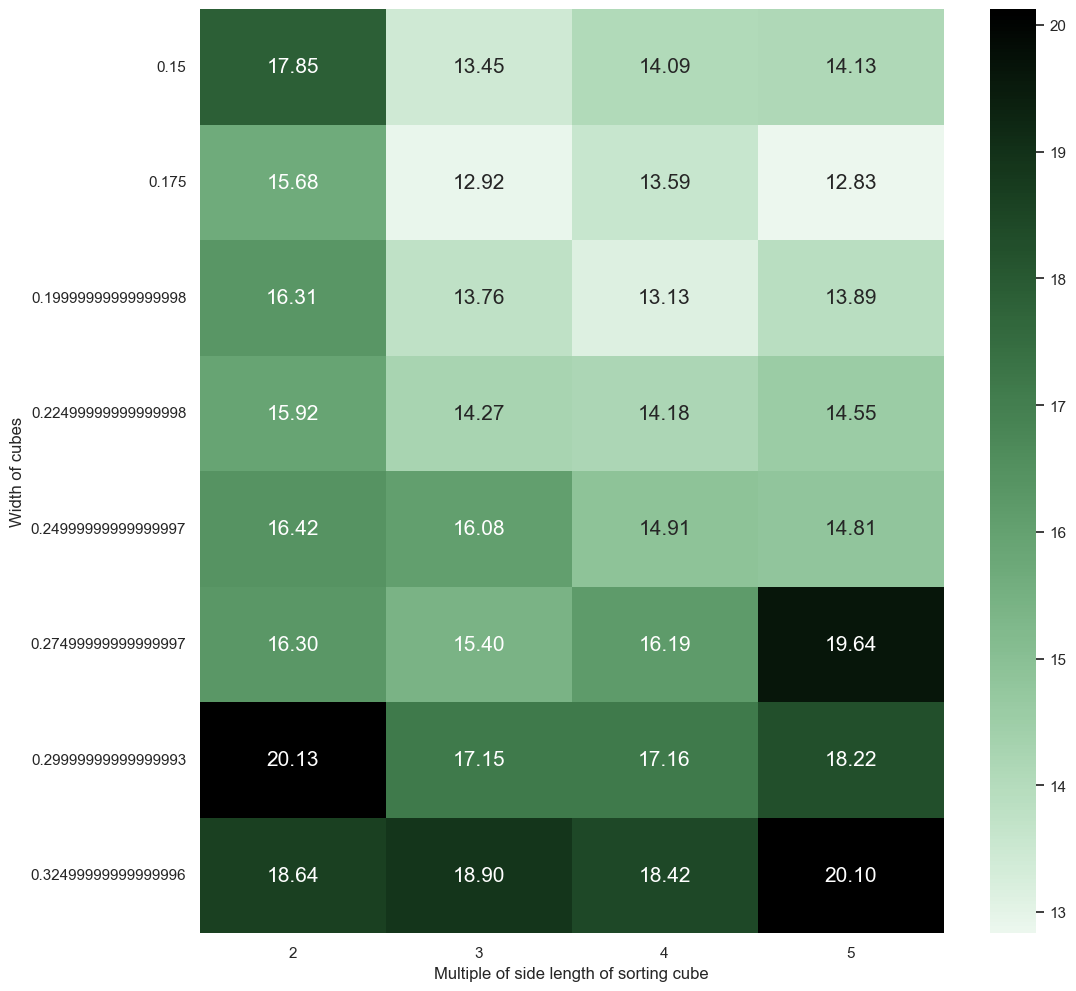

In [10]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
color_map = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)
sns.set(font_scale=1)
plt.figure(figsize=(12,12))
ax = sns.heatmap(total_times, annot=True, xticklabels=range_sort_width_multiple, yticklabels=range_cube_width, fmt=".2f", cmap=color_map, annot_kws={"size": 15})
plt.xlabel('Multiple of side length of sorting cube')
plt.ylabel('Width of cubes')